# Train model using the fastai library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import packages

In [96]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import scipy.io.wavfile
import torch
from fastai.vision import *
from fastai.metrics import error_rate

import IPython.display as ipd
from tqdm import tqdm_notebook

## Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [4]:
path_img = "../mfc_dataset"
fnames = sorted(get_image_files(path_img))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]

[PosixPath('../mfc_dataset/female_3075.jpg'),
 PosixPath('../mfc_dataset/male_3161.jpg'),
 PosixPath('../mfc_dataset/male_4055.jpg'),
 PosixPath('../mfc_dataset/male_5550.jpg'),
 PosixPath('../mfc_dataset/female_3396.jpg')]

In [5]:
data = ImageDataBunch.from_name_re(
    path_img, fnames, pat, size=224, bs=64, valid_pct=0.2, seed=42
).normalize(imagenet_stats)

For more information on batch size selection, see https://forums.fast.ai/t/how-to-check-your-pytorch-keras-is-using-the-gpu/7232/3.

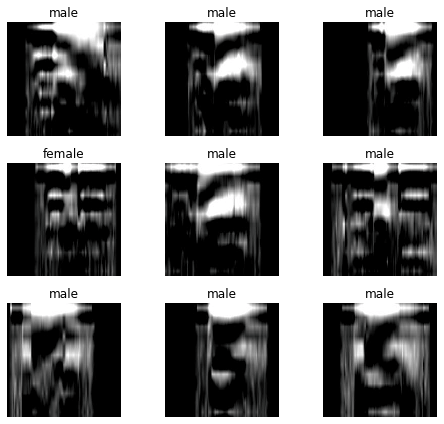

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['female', 'male']


(2, 2)

## Train ResNet34

### Transfer learning step 1: Only retrain the classifier

Instantiate a learner using data, model and metric:

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

**Note**: Since the model is already trained, you can now directly jump to "Evaluate model" to avoid retraining the model.

Verify the availability of GPU(s):

In [9]:
torch.cuda.is_available()

True

Find a good learning rate: (https://docs.fast.ai/callbacks.lr_finder.html)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


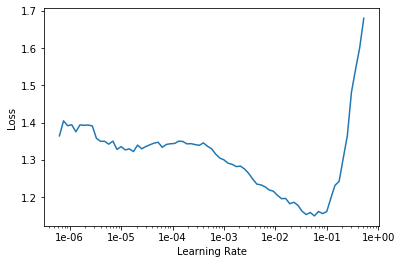

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.235953,0.149880,0.059833,02:59
1,0.117766,0.091652,0.035167,02:58


Our model is pretty accurate after only 2 epochs.

### Transfer learning step 2: Retrain the entire model

After retraining the classifier, let's also train the convolutional layers.

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.048189,0.028704,0.010667,04:17


<div style="text-align: justify">
In the context of this dataset, unfreezing and retraining the entire model sometimes do not increase its performance - but sometimes it does. For this reason, I left it here. 
</div>

In [16]:
learn.export()

## Evaluate model

### Identify outliers

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model = load_learner(path_img).model
# ClassificationInterpretation.from_learner requires the learn to has validation data.
# However, load_learner(path_img) does not have validation data.
# Therefore, I had to use the workaround above.

In [11]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

In [12]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

<div style="text-align: justify">
The outliers displayed as MFCs and the Grad-CAM heatmaps are not intuitive because we humans can't read off sounds from MFCs:
</div>

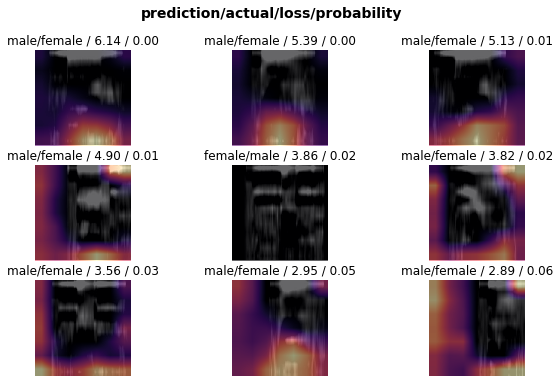

In [14]:
interp.plot_top_losses(9, figsize=(10, 6), heatmap=True)

Instead, let's try hearing the top losses.

In [15]:
def load_json(json_fpath):
    with open(json_fpath, 'r') as json_f:
        return json.load(json_f)

In [18]:
male_idxs_to_wav_fpaths   = load_json('../maps/male_idxs_to_wav_fpaths.json')
female_idxs_to_wav_fpaths = load_json('../maps/female_idxs_to_wav_fpaths.json')

In [39]:
# reference: https://forums.fast.ai/t/how-to-get-data-val-ds-fnames-in-fastai-v1-0/37231
for mfc_path in data.valid_ds.x.items[idxs][:5]:
    mfc_path = str(mfc_path)
    print(mfc_path, end='|')
    wav_fpath = female_idxs_to_wav_fpaths[mfc_path] if 'female' in mfc_path else male_idxs_to_wav_fpaths[mfc_path]
    print(wav_fpath)
    ipd.display(ipd.Audio(wav_fpath))

../mfc_dataset/female_4800.jpg|../../AudioMNIST/data/59/5_59_35.wav


../mfc_dataset/female_1638.jpg|../../AudioMNIST/data/59/1_59_8.wav


../mfc_dataset/female_1035.jpg|../../AudioMNIST/data/59/5_59_44.wav


../mfc_dataset/female_2622.jpg|../../AudioMNIST/data/56/8_56_7.wav


../mfc_dataset/male_14291.jpg|../../AudioMNIST/data/25/6_25_31.wav


### Confusion matrix

The confusion matrix and the F1 score are commonly used to evaluate classifiers:

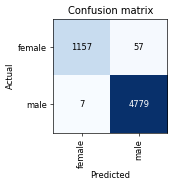

In [24]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

### F1 score

Since this is a binary classification task, we can think of "female" as "true" and "male as "false".

In [25]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)

This classifier has a super high F1 score. 

In [26]:
f1_score

0.9730866274179985

### Where is the model looking?

This is an example of how to use fastai's GradCAM functionality:
- idx: the index of the image to use for GradCAM (the image is obtained by indexing into interp.ds)
- image: whether to show GradCAM result on top of the image

In [189]:
cam = interp.GradCAM(idx=3, image=False)

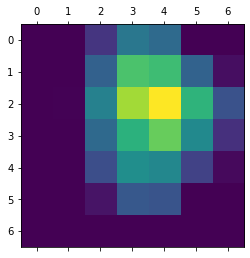

In [191]:
plt.matshow(cam, interpolation=None)
plt.show()

One can make the GradCAM result look better using interpolation:

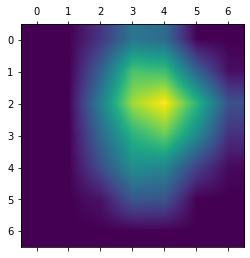

In [192]:
plt.matshow(cam, interpolation='bilinear')
plt.show()

We can compute a mean GradCAM result for each category.

In [93]:
data.c2i

{'female': 0, 'male': 1}

In [101]:
binary_labels = []
for cat in interp.ds.y:  # use data.valid_ds.y.get(index) for individual use cases
    binary_labels.append(cat.data)

In [222]:
male_cam_json_fpath = '../results/male_cams.json'
female_cam_json_fpath = '../results/female_cams.json'

In [234]:
if not (os.path.isfile(male_cam_json_fpath) and os.path.isfile(female_cam_json_fpath)):
    recompute_cam = True
else:
    recompute_cam = False

In [238]:
if recompute_cam:
    
    male_cams, female_cams = [], []
    for i, label in tqdm_notebook(enumerate(binary_labels), total=len(interp.ds)):
        
        cam = interp.GradCAM(idx=i, image=False)
        
        if label == 0:  # female
            female_cams.append(cam)
        elif label == 1:  # male
            male_cams.append(cam)
    
    male_cams = np.array([cam.numpy() for cam in male_cams])
    female_cams = np.array([cam.numpy() for cam in female_cams])

In [236]:
if recompute_cam:
    with open(male_cam_json_fpath, 'w+') as json_f:
        json.dump(male_cams.tolist(), json_f) 
else:
    print(f'Loading {male_cam_json_fpath}!')
    male_cams = np.array(load_json(male_cam_json_fpath))

Loading ../results/male_cams.json!


In [237]:
if recompute_cam:
    with open('../results/female_cams.json', 'w+') as json_f:
        json.dump(female_cams.tolist(), json_f) 
else:
    print(f'Loading {female_cam_json_fpath}!')
    female_cams = np.array(load_json(female_cam_json_fpath))

Loading ../results/female_cams.json!


<div style="text-align: justify">
Now the GradCAM results are computed for each class. The mean GradCAM result for each class can then be computed.
</div>

In [283]:
male_cam_summary = np.mean(male_cams, axis=0)
male_cam_summary /= male_cam_summary.max()

In [284]:
female_cam_summary = np.mean(female_cams, axis=0)
female_cam_summary /= female_cam_summary.max()

Visualize the mean GradCAM result for each class.
- mention interpolation

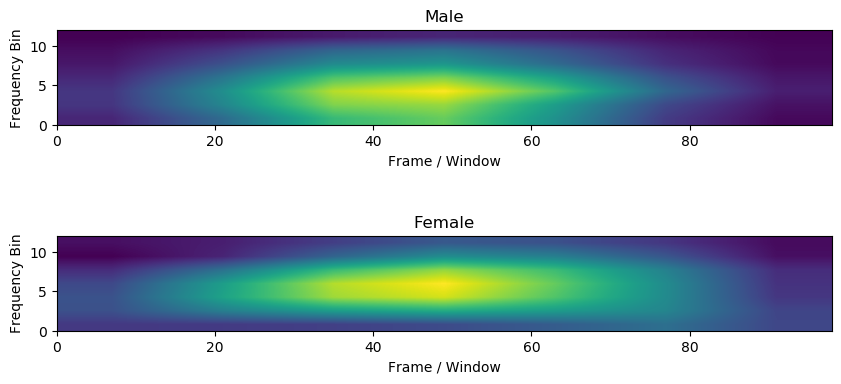

In [335]:
fig = plt.figure(figsize=(10, 5), dpi=100)

ax = fig.add_subplot(211)
ax.imshow(male_cam_summary, extent=(0, 98, 12, 0), interpolation='bilinear')
plt.gca().invert_yaxis()
plt.title('Male')
plt.xlabel('Frame / Window'); plt.ylabel('Frequency Bin')

ax = fig.add_subplot(212)
ax.imshow(female_cam_summary, extent=(0, 98, 12, 0), interpolation='bilinear')
plt.gca().invert_yaxis()
plt.title('Female')
plt.xlabel('Frame / Window'); plt.ylabel('Frequency Bin')

plt.show()

In [384]:
male_cam_freqwise_mean = male_cam_summary.mean(axis=1)
male_cam_freqwise_mean /= male_cam_freqwise_mean.max()

In [385]:
female_cam_freqwise_mean = female_cam_summary.mean(axis=1)
female_cam_freqwise_mean /= female_cam_freqwise_mean.max()

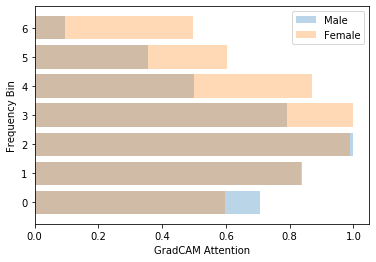

In [390]:
plt.barh(np.arange(len(male_cam_freqwise_mean)), male_cam_freqwise_mean, alpha=0.3, label='Male')
plt.barh(np.arange(len(female_cam_freqwise_mean)), female_cam_freqwise_mean, alpha=0.3, label='Female')
plt.xlabel('GradCAM Attention')
plt.ylabel('Frequency Bin')
plt.legend()
plt.show()